## Predicting human activity from smart phone sensory data

### Introduction

In this notebook, the human activity recognition dataset having records of acceleration and angular velocity measurements from different physical aspects in all three spatial dimensions (X, Y, Z) is used to train a machine and predict the activity from one of the six activities performed. 

To start with, let's do some exploratory analysis in hope of understanding various measures and their effect on the activities.

In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb
%matplotlib inline

In [6]:
train = pd.read_csv("/Users/babburi/datasets/HAR/samsungData.csv")

In [7]:
print(train.shape,'\n', train.columns)

(7352, 563) 
 Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-kurtosis()', 'angle(tBodyAccMean,gravity)',
       'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'subject', 'activity'],
      dtype='object', length=563)


### Exploratory Analysis
The training data has 7352 observations with 563 variables with the first few columns representing the mean and standard deviations of body accelerations in 3 spatial dimensions (X, Y, Z). The last two columns are "subject" and "acitivity" which represent the subject that the observation is taken from and the corresponding activity respectively. We can infer that this data is supposed to train machines to recognize activity collected from the accelerometers and gyroscopes built into the smartphones that the subjects had strapped to their waists.

Let's see what activities have been recorded in this data.

In [8]:
train['activity'].unique()

array(['standing', 'sitting', 'laying', 'walk', 'walkdown', 'walkup'], dtype=object)

We have 6 activities, 3 passive (laying, standing and sitting) and 3 active (walk, walkdown, walkup) which involve walking. So, each observation in the dataset represent one of the six acitivities whose features are recorded in the 561 variables. Our goal would be trian a machine to predict one of the six activities given a feature set of 561 variables.

Let's check how many observations are recorded by each subject.

In [9]:
pd.crosstab(train.subject, train.activity)

activity,laying,sitting,standing,walk,walkdown,walkup
subject,,,,,,
1,50,47,53,95,49,53
3,62,52,61,58,49,59
5,52,44,56,56,47,47
6,57,55,57,57,48,51
7,52,48,53,57,47,51
8,54,46,54,48,38,41
11,57,53,47,59,46,54
14,51,54,60,59,45,54
15,72,59,53,54,42,48


It is good that the data is almost evenly distributed for all the activities among all the subjects. Let's pick subject 15 and compare the activities with the first three variables - mean body acceleration in 3 spatial dimensions.

In [10]:
sub15 = train.loc[train['subject']==15]

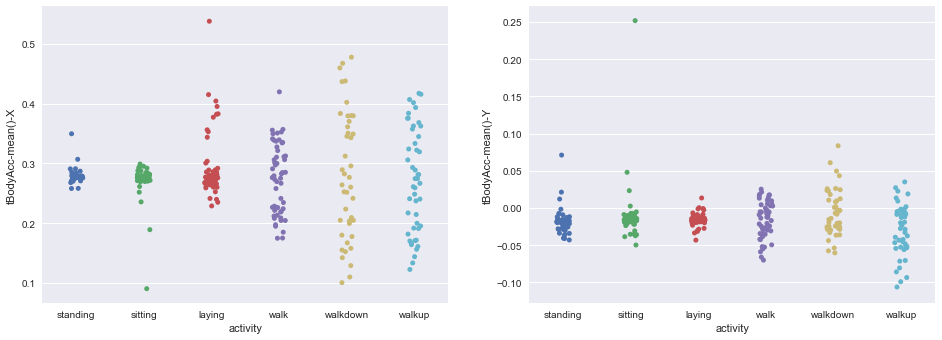

In [11]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(221)
ax1 = sb.stripplot(x='activity', y=sub15.iloc[:,0], data=sub15, jitter=True)
ax2 = fig.add_subplot(222)
ax2 = sb.stripplot(x='activity', y=sub15.iloc[:,1], data=sub15, jitter=True)
plt.show()

So, the mean body acceleration is more variable for walking activities than for passive ones especially in the X direction. Let's create a dendrogram and see if we can discover any structure with mean body acceleration.

/Users/babburi/anaconda/envs/pyEnv_3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


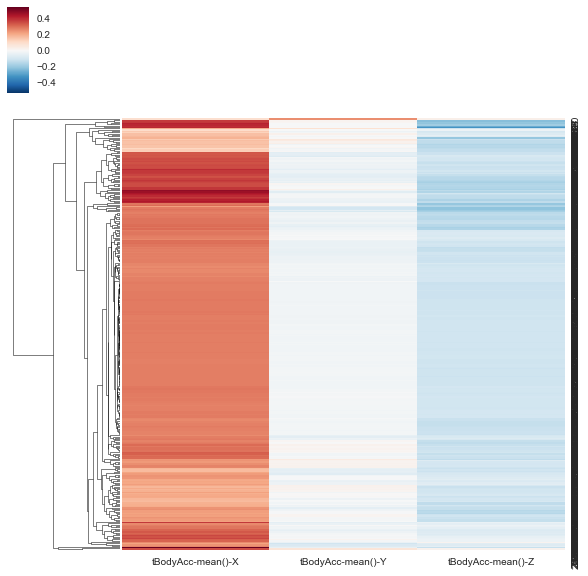

In [12]:
sb.clustermap(sub15.iloc[:,[0,1,2]], col_cluster=False)

Even though we see some dark spots in the X and Z directions (possibly from the walking activities), the bulk of the map is pretty homogenous and does not help much. Perhaps other attributes like maximum or minimum acceleration might give us a better insight than the average.

Plotting maximum acceleration with activity.

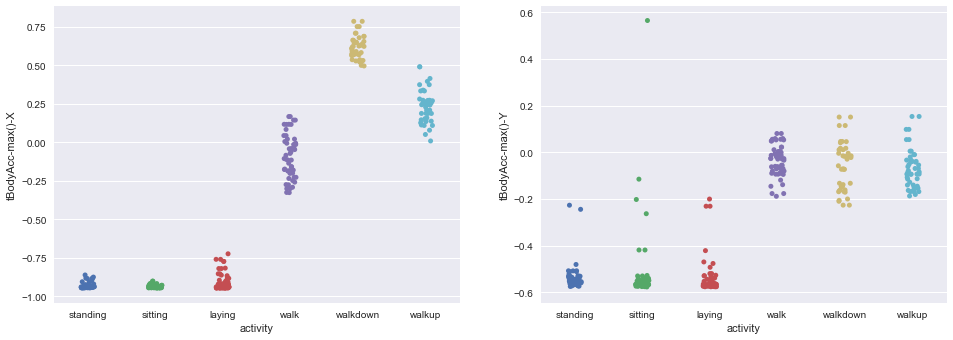

In [13]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(221)
ax1 = sb.stripplot(x='activity', y='tBodyAcc-max()-X', data=sub15, jitter=True)
ax2 = fig.add_subplot(222)
ax2 = sb.stripplot(x='activity', y='tBodyAcc-max()-Y', data=sub15, jitter=True)
plt.show()

That's interesting! Passive activities fall mostly below the active ones. It actually makes sense that maximum acceleration is higher during the walking activities. Let's again plot the cluster map but this time with maximum acceleration. Notice the walkdown acitivity is above all others in the X-direction recording values between 0.5 and 0.8.

/Users/babburi/anaconda/envs/pyEnv_3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


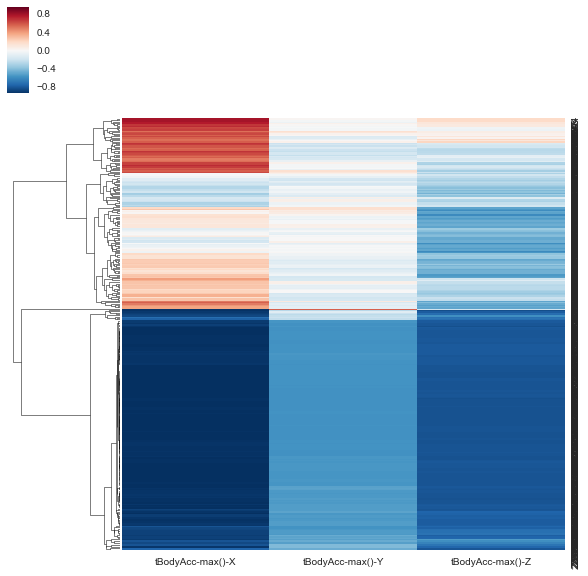

In [14]:
sb.clustermap(sub15[['tBodyAcc-max()-X', 'tBodyAcc-max()-Y', 'tBodyAcc-max()-Z']], col_cluster=False)

We can now see the difference in the distribution between the active and passive activities with the walkdown activity (values between 0.5 and 0.8) clearly distinct from all others especially in the X-direction. The passive activities are indistinguishable and present no clear pattern in any direction (X, Y, Z).

### Clustering using KMeans
Now, let us cluster the entire data using KMeans algorithm.

In [15]:
from sklearn.cluster import KMeans

In [16]:
kmeans = KMeans(n_clusters=6).fit(sub15.iloc[:,:-2])

In [17]:
clust = pd.crosstab(kmeans.labels_, sub15['activity'])
clust

activity,laying,sitting,standing,walk,walkdown,walkup
row_0,,,,,,
0,56,0,0,0,0,0
1,0,0,0,0,0,48
2,16,15,13,0,0,0
3,0,0,0,0,42,0
4,0,44,40,0,0,0
5,0,0,0,54,0,0


Upon clustering using kmeans, all the walking activities seem to separate out while the passive ones are still mixed. All three Laying, Sitting and Standing are distributed in two different clusters. 

In [18]:
kmeans.cluster_centers_.shape

(6, 561)

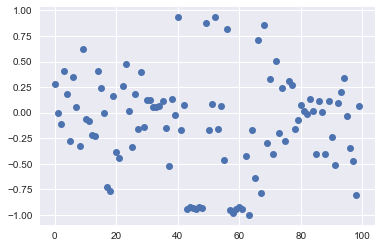

In [19]:
plt.plot(kmeans.cluster_centers_[np.asscalar(clust[clust.walkdown!=0].index),:100], "o")

Here is a plot of first 100 columns for the cluster mapped to 'walkdown' acitivity. The column 40 and a few around 50 seems to be the dominant columns for this cluster center. Let's see what these are.

In [20]:
print(sub15.columns[[40, 50, 51]])

Index(['tGravityAcc-mean()-X', 'tGravityAcc-max()-Y', 'tGravityAcc-max()-Z'], dtype='object')


So, the different aspects of gravity have the most effect on 'walkdown' activity which makes perfect sense. Let's make a similar plot for 'sitting' and as it is distributed in two clusters (2 and 5), I am picking cluster 5 since it contains all three passive activities to find out what the dominant columns are.

Even though we could not find a clear pattern with any of the passive activities from the analysis so far, it can be inferred that the sensory measurements seem pretty good in order to train a machine and make predictions on new examples.

## Training
In this section, I am going to train a model in TensorFlow using the train set and predict the activity using the test set.

In [21]:
import tensorflow as tf

In [22]:
# load train and test data
train_x = np.loadtxt('/Users/babburi/datasets/HAR/train/X_train.txt')
train_y = np.loadtxt('/Users/babburi/datasets/HAR/train/y_train.txt')
train_y = np.eye(6)[train_y.astype('int')-1] # one-hot encoding
test_x = np.loadtxt('/Users/babburi/datasets/HAR/test/X_test.txt')
test_y = np.loadtxt('/Users/babburi/datasets/HAR/test/y_test.txt')
test_y = np.eye(6)[test_y.astype('int')-1]

# shuffle the data
seed = 456
np.random.seed(seed)
np.random.shuffle(train_x)
np.random.seed(seed)
np.random.shuffle(train_y)
np.random.seed(seed)
np.random.shuffle(test_x)
np.random.seed(seed)
np.random.shuffle(test_y)

### Softmax Classifier

Training a softmax classifier and using gradient descent to optimize the weights.

In [23]:
# place holder variable for x with number of features - 561
x = tf.placeholder('float', [None, 561], name='x')
# place holder variable for y with the number of activities - 6
y = tf.placeholder('float', [None, 6], name='y')
# softmax model
def train_softmax(x):
    W = tf.Variable(tf.zeros([561, 6]), name='weights')
    b = tf.Variable(tf.zeros([6]), name='bias')
    lr = 0.25
    prediction = tf.nn.softmax(tf.matmul(x, W) + b, name='op_predict')
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = prediction, labels = y))
    optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost)
    
    sess = tf.InteractiveSession()
    tf.global_variables_initializer().run()
    for epoch in range(1000):
        loss = 0
        _, c = sess.run([optimizer, cost], feed_dict = {x: train_x, y: train_y})
        loss += c
        if (epoch % 100 == 0 and epoch != 0):
            print('Epoch', epoch, 'completed out of', 1000, 'Training loss:', loss)
    correct = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='op_accuracy')
    
    print('Train set Accuracy:', sess.run(accuracy, feed_dict = {x: train_x, y: train_y}))
    print('Test set Accuracy:', sess.run(accuracy, feed_dict = {x: test_x, y: test_y}))


In [24]:
train_softmax(x)

Epoch 100 completed out of 1000 Training loss: 1.23762512207
Epoch 200 completed out of 1000 Training loss: 1.20673799515
Epoch 300 completed out of 1000 Training loss: 1.16777598858
Epoch 400 completed out of 1000 Training loss: 1.1546690464
Epoch 500 completed out of 1000 Training loss: 1.14524233341
Epoch 600 completed out of 1000 Training loss: 1.1378569603
Epoch 700 completed out of 1000 Training loss: 1.13166248798
Epoch 800 completed out of 1000 Training loss: 1.12628424168
Epoch 900 completed out of 1000 Training loss: 1.12151241302
Train set Accuracy: 0.953482
Test set Accuracy: 0.93417


After training for 1000 iterations, we got a test accuracy of approximately 93%.

### Neural Network Classifier

Training using a simple artificial neural network with one hidden layer

In [25]:
n_nodes_input = 561 # number of input features
n_nodes_hl = 30     # number of units in hidden layer
n_classes = 6       # number of activities
x = tf.placeholder('float', [None, 561])
y = tf.placeholder('float')

In [26]:
def neural_network_model(data):
    # define weights and biases for all each layer
    hidden_layer = {'weights':tf.Variable(tf.truncated_normal([n_nodes_input, n_nodes_hl], stddev=0.3)),
                      'biases':tf.Variable(tf.constant(0.1, shape=[n_nodes_hl]))}
    output_layer = {'weights':tf.Variable(tf.truncated_normal([n_nodes_hl, n_classes], stddev=0.3)),
                    'biases':tf.Variable(tf.constant(0.1, shape=[n_classes]))}
    # feed forward and activations
    l1 = tf.add(tf.matmul(data, hidden_layer['weights']), hidden_layer['biases'])
    l1 = tf.nn.sigmoid(l1)
    output = tf.matmul(l1, output_layer['weights']) + output_layer['biases']
    
    return output

In [27]:
def train_neural_network(x):
    prediction = neural_network_model(x)
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y,logits=prediction))
    optimizer = tf.train.AdamOptimizer().minimize(cost)
    
    sess = tf.InteractiveSession()
    tf.global_variables_initializer().run()
    for epoch in range(1000):
        loss = 0
        _, c = sess.run([optimizer, cost], feed_dict = {x: train_x, y: train_y})
        loss += c
        if (epoch % 100 == 0 and epoch != 0):
            print('Epoch', epoch, 'completed out of', 1000, 'Training loss:', loss)
    correct = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='op_accuracy')
    
    print('Train set Accuracy:', sess.run(accuracy, feed_dict = {x: train_x, y: train_y}))
    print('Test set Accuracy:', sess.run(accuracy, feed_dict = {x: test_x, y: test_y}))

In [28]:
train_neural_network(x)

Epoch 100 completed out of 1000 Training loss: 0.33050480485
Epoch 200 completed out of 1000 Training loss: 0.246439412236
Epoch 300 completed out of 1000 Training loss: 0.181686475873
Epoch 400 completed out of 1000 Training loss: 0.134458482265
Epoch 500 completed out of 1000 Training loss: 0.104431286454
Epoch 600 completed out of 1000 Training loss: 0.0835607722402
Epoch 700 completed out of 1000 Training loss: 0.0684749111533
Epoch 800 completed out of 1000 Training loss: 0.0571113191545
Epoch 900 completed out of 1000 Training loss: 0.048492975533
Train set Accuracy: 0.980277
Test set Accuracy: 0.953512


Training using the neural network gave us a test accuracy of about 95%. Notice that I did not specify any learning rate here and used just the default from tensorflow. 